<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://media.licdn.com/dms/image/C4D12AQH-T7BYWr9clg/article-inline_image-shrink_1500_2232/0?e=2120536800&v=alpha&t=RrGrsyl8QPtDQjdKKw6VpEbJrTq1Dnigk89_t9vhbfw)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually.

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 376 ms, sys: 688 ms, total: 1.06 s
Wall time: 577 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
vocabulary = list()
for each_img_cap in range(len(captions)):
    current_img_cap = captions[each_img_cap]
    for each_unary_cap in range(len(captions[each_img_cap])):
        vocabulary += captions[each_img_cap][each_unary_cap]
vocabulary = np.array(vocabulary, dtype=np.str)

In [6]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

#Compute word frequencies for each word in captions. See code above for data structure
for word in vocabulary:
    word_counts[word] +=1

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [9]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

In [10]:
as_matrix(captions[546])

array([[   1,   24,  664, 2346,  192,  662,  658,  193,  117,   24, 2347,
         981,   12,    2,    3,    3,    3,    3],
       [   1,   24,  526,   14,  662,   41,   35,   24,  291,    2,    3,
           3,    3,    3,    3,    3,    3,    3],
       [   1,  291,   58,   24,  662,  658,  193,  117,   45,  346,   14,
          45,  662,  710,   35,   45, 1091,    2],
       [   1,   24,  288,   71,   58,   24,   47,  291,   51,   24,  658,
          14,  662,   12,    2,    3,    3,    3],
       [   1,  662,   15,  109,  182,  140,   35, 1210,   18,   24,   71,
          58,   24,  981,   12,    2,    3,    3]], dtype=int32)

In [11]:
as_matrix(captions[12])

array([[  1,  24, 106,  14,   4,  35,  24, 202,   6,  24, 203,   2,   3,
          3,   3,   3],
       [  1,  24, 106,  14,   4,  35,  24, 127,  15,  46, 202, 193, 117,
        194,  12,   2],
       [  1,   4,  35, 204,  78, 146,  24, 203,  58, 205,  35,  45, 206,
         12,   2,   3],
       [  1, 207,  89,  35,  24,   0, 208,   6, 209,   2,   3,   3,   3,
          3,   3,   3],
       [  1, 210,   4,  35,  24, 202,  17, 211, 212,  31,  45, 203,  12,
          2,   3,   3]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [12]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [13]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb =nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb =self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        
        #captions_emb = torch.cat((initial_cell.unsqueeze(1), captions_emb), 1)
    
        lstm_out,_ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        #logits = F.softmax(logits)
        return logits        

In [14]:
network = CaptionNet(n_tokens).cuda()

/home/use/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:97: UserWarning: 
    Found GPU1 Quadro K2200 which is of cuda capability 5.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [15]:
dummy_img_vec = Variable(torch.randn(len(captions[0]), 2048).cuda())
dummy_capt_ix = Variable(torch.LongTensor(as_matrix(captions[0]).tolist()).cuda())

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix).cpu().data

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.cpu().data.shape[0], dummy_capt_ix.cpu().data.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [16]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: a Variable containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: a Variable containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float Variable
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous().view(-1)
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors.cuda(), captions_ix_inp.cuda()).view(-1, n_tokens)
    
    #encoded_true = Variable(encode(captions_ix_next))
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next == pad_ix)
    # or by using ignore_index in some losses.
    #return encoded_true, logits_for_next.cpu()
    
    #loss = F.cross_entropy(logits_for_next.permute(0,2,1), captions_ix_next, ignore_index=pad_ix)
    
    loss = F.cross_entropy(logits_for_next, captions_ix_next)
    loss = loss[captions_ix_next.view(-1) !=pad_ix]
    
    return torch.mean(loss)

In [17]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.cpu().data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [18]:
#opt = torch.optim.Adadelta(network.parameters())
opt = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [19]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [20]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return Variable(torch.FloatTensor(batch_images).cuda()), Variable(torch.LongTensor(batch_captions_ix).cuda())
    

In [21]:
generate_batch(img_codes,captions,3)

(Variable containing:
  0.0846  0.1539  0.1927  ...   0.8202  0.4751  0.0763
  0.2436  0.0675  0.5577  ...   0.0886  0.1762  0.1318
  0.4913  0.2358  0.5922  ...   0.0632  0.7130  0.2685
 [torch.cuda.FloatTensor of size 3x2048 (GPU 0)], Variable containing:
     1    45    48    41   140    35    45   401  1673     2     3     3
     1    24  1051    63   136  1596   726    45   578     2     3     3
     1    24    21   372    15   210     4    35    24   103    12     2
 [torch.cuda.LongTensor of size 3x12 (GPU 0)])

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [22]:
import matplotlib.pyplot as plt
%matplotib notebook

ERROR:root:Line magic function `%matplotib` not found.


In [23]:
batch_size = 100  # adjust me
n_epochs = 37  # adjust me
n_batches_per_epoch = 170  # adjust me
n_validation_batches = 55  # how many batches are used for validation after each epoch

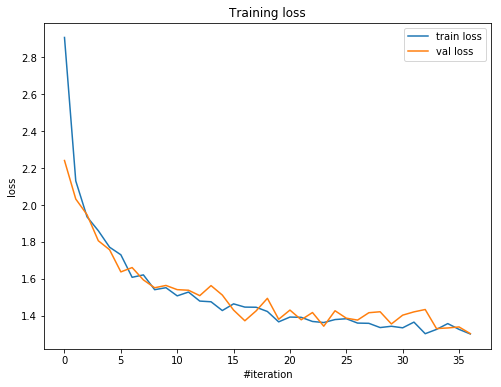

Current loss: 1.300710
Finished!


In [24]:
from IPython import display
from tqdm import tqdm_notebook

train_loss_list, val_loss_list = list(), list()

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        
        opt.zero_grad()
        
        train_loss += loss_t.cpu().data.numpy()[0]
        
    train_loss /= n_batches_per_epoch
    train_loss_list.append(train_loss)
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.cpu().data.numpy()[0]
    val_loss /= n_validation_batches
    val_loss_list.append(val_loss)
    
    #print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(train_loss_list, label='train loss')
    plt.plot(val_loss_list, label='val loss')
    plt.legend()
    plt.show()
    
    print('Current loss: %f' % train_loss)
    
print("Finished!")

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [25]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/home/use/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [26]:
def generate_caption(image, caption_prefix = ("START",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = Variable(torch.FloatTensor(image.transpose([2, 0, 1])), volatile=True)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = Variable(torch.LongTensor(prefix_ix).cuda(), volatile=True)
        next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).cpu().data.numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [27]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2018-04-25 23:45:03--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.112.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.112.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 107 928     --.-K/s   in 0,1s    

2018-04-25 23:45:03 (749 KB/s) - ‘data/img.jpg’ saved [107928/107928]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


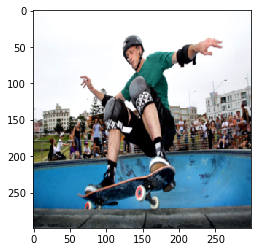

In [28]:
plt.imshow(img)

In [29]:
for i in range(10):
    print(' '.join(generate_caption(img, t=2.5)[1:-1]))

a man in a white shirt is doing a trick on a skateboard .
a man in a skateboard jump on a ramp .
a man riding a skateboard on a ramp .
a man is riding a skateboard down a ramp .
a man is doing a trick on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a man on a skateboard doing tricks on a skateboard .
a man riding a skateboard on a ramp .
a man is doing a trick on a skateboard .


--2018-04-25 23:47:48--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

100%[======================================>] 106 870      190KB/s   in 0,5s   

2018-04-25 23:47:48 (190 KB/s) - ‘data/img.jpg’ saved [106870/106870]



/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


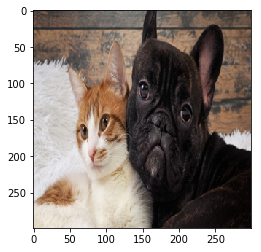

a black and white photo of a cat .
a black dog is sleeping on a couch .
a black cat is laying down with a remote .
a black cat is laying on a bed .
a black and white cat sitting on top of a couch .
a black cat laying on a bed with a blanket .
a cat sitting on a bed next to a laptop
a black dog on a bed with a white cat on it's face .
a black and white cat sitting on top of a wood floor .
a black dog that is sleeping on a bed .


In [53]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('imgs/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=1.5)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

 - ###### IMG 1

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


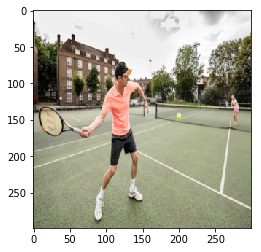

a man in a white shirt and a white shirt playing tennis .
a man is playing tennis on a tennis court .
a man in a white shirt is playing tennis .
a tennis player is playing a game of tennis .
a man is playing tennis on a tennis court .
a man swinging a tennis racket on a tennis court .
a man holding a tennis racquet on a tennis court .
a man with a tennis racket on a tennis court .
a man is playing tennis on a court .
a young man holding a tennis racket and ball .


In [31]:
img = plt.imread('imgs/1')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.5)[1:-1]))

 - ###### IMG 2

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


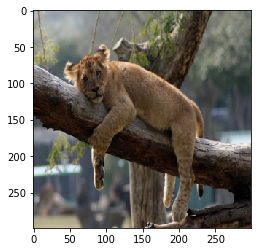

a white and brown dog is sitting on a log
a brown and white cat sitting on a wooden bench .
a small white and white dog is sitting on a wooden bench .
a cat is standing in the grass near a fence .
a brown and white dog in a zoo enclosure .
a brown and white dog sitting on top of a wooden chair .
a brown and white cat standing on a wooden floor .
a large white cat standing in the grass .
a black and white cat sitting on a wooden floor .
a brown and white cat is standing in the grass .


In [32]:
img = plt.imread('imgs/2.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.5)[1:-1]))

 - ###### IMG 3

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


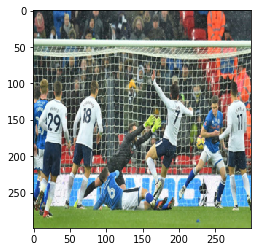

a group of people standing in front of a building .
a group of people standing on the street with a basketball .
a group of people standing in front of a building .
a group of people standing around in a field .
a group of people standing around a fence and a man holding a baseball bat .
a man in a blue shirt standing on a skateboard .
a group of young men standing next to each other .
a group of people standing in a field next to a white house .
a man with a tennis racket on a court .
a group of people standing on a tennis court .


In [33]:
img = plt.imread('imgs/3.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.5)[1:-1]))

 - ###### IMG 4

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


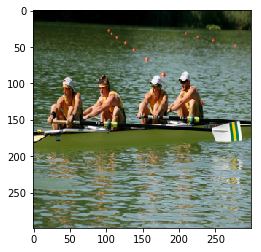

a group of people on a boat in the water .
a group of people are sitting on a wooden bench
a group of people sitting on a boat in the water .
a group of people in a boat on a lake .
a group of people on a boat in the water .
a group of people on a boat on a river .
a group of people on a boat in the water .
a group of people on a boat in the water .
a group of people on a boat on a lake .
a group of people are on a beach with a boat in the background .


In [34]:
img = plt.imread('imgs/4.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

 - ###### IMG 5

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


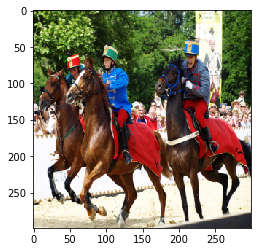

a man riding a horse and a woman on a horse .
a woman riding on a horse in the back of a crowd .
a man riding a horse and a horse drawn carriage in the background .
a man riding a horse in front of a horse .
a man with a hat and a horse and a horse .
two people riding horses ride in the snow .
a man riding a horse in a field .
a woman in a white shirt and a white horse .
a group of people riding horses on a track .
a woman in a white shirt and a black horse


In [35]:
img = plt.imread('imgs/5.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.5)[1:-1]))

 - ###### IMG 6

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


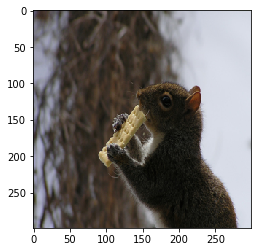

a black and white photo of a toilet and animal on the ground .
a gray and white bird is sitting in the brush .
a bird is on the edge of a tree .
a brown and white puppy sitting on a dirt field .
a bird that is perched on top of a tree .
a bird perched on top of a tree covered in water .
a black looking bird is perched on a branch .
a black and white photo of a metal fence
a brown teddy bear is standing in the grass .
a grey and white photograph of a baby giraffe .


In [36]:
img = plt.imread('imgs/6.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=1.5)[1:-1]))

 - ###### IMG 7

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


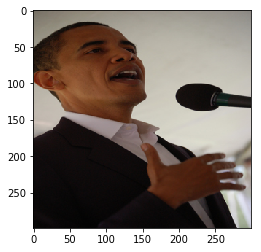

a man in a suit and tie with a tie .
a man in a suit with a tie in his mouth .
a man in a suit and tie in a suit .
a man in a suit and tie with a tie .
a man in a suit and tie with a hat .
a man in a suit and tie with a hat
a man in a suit and tie standing in a kitchen .
a man in a suit and tie standing in a kitchen .
a man in a suit and tie in a suit .
a man in a suit and tie with a tie .


In [37]:
img = plt.imread('imgs/7.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=4.5)[1:-1]))

 - ###### IMG 8

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


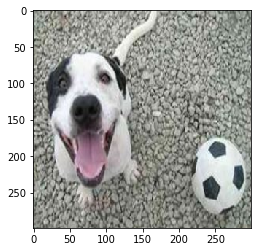

a small dog is sitting on a floor next to a red frisbee .
a dog is sitting on the grass next to a frisbee .
a woman looking at a frisbee in a grassy field .
a dog with a frisbee in its mouth in a grassy field .
a small dog that is standing in the grass .
a group of young children playing with a frisbee .
a dog is playing with a frisbee in its mouth .
a dog with a frisbee in its mouth .
a dog is standing in a field with a frisbee .
a dog is standing in the grass next to a frisbee .


In [38]:
img = plt.imread('imgs/8.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.5)[1:-1]))

 - ###### IMG 9

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


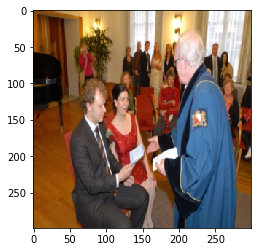

a group of people standing around a living room .
a group of people standing around a table .
a group of people standing around a table .
a group of people standing next to each other .
two people standing next to each other in a living room .
a group of people standing next to each other .
a man and woman are standing in a room .
a man and woman are standing in a room with a laptop .
a group of people standing in a kitchen next to a man .
a group of people sitting around a table eating .


In [39]:
img = plt.imread('imgs/9.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.5)[1:-1]))

 - ###### IMG 10

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


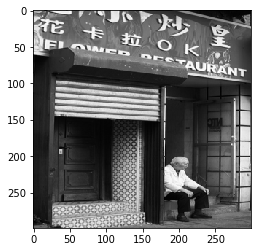

a man standing in front of a building with a clock on it .
a man standing in front of a refrigerator with a sign on it .
a man standing in front of a building with a giant clock .
a man is sitting on a bench in a room
a woman is standing in front of a refrigerator .
a man is standing in front of a wall with a phone .
a man in a white shirt is holding a glass of wine .
a man in a black shirt is holding a cell phone .
a man in a black shirt is holding a sandwich .
a man sitting on a bench in front of a building .


In [40]:
img = plt.imread('imgs/10.jpeg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=3.)[1:-1]))

##### P.S. Cool homework. Cheers

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563